# Selection on HDF5 Files

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotting_tools as pt
import random
import time

%load_ext autoreload
%autoreload 2

## Selection Criteria

In [5]:
# ----- Run & LDC Information ----- #
run_id = 15205
ldc_id = 1

# ----- Load HDF5 File ----- #
data_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/'
h5_path  = os.path.join(data_dir, f'run_{run_id}_ldc_{ldc_id}_custom_sophronia.h5')

# Table paths inside the HDF5 file. These are the keys used to access the datasets.
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

try:  
        # ----- Dorothea ----- #
        dst_df = pd.read_hdf(h5_path, key=dorothea)
        
        print(f"'{dorothea}' loaded successfully!")
        print(f"DataFrame dimensions (rows, columns): {dst_df.shape}")
        print(f"Available columns: {dst_df.columns.tolist()}")

except Exception as e:
        print(f"Error: Unexpected error processing file '{h5_path}'\n{e}")

'DST/Events' loaded successfully!
DataFrame dimensions (rows, columns): (17724, 19)
Available columns: ['event', 'time', 'nS1', 'nS2', 'S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT', 'Z', 'X', 'Y']


### $S2e$ vs $S1e$

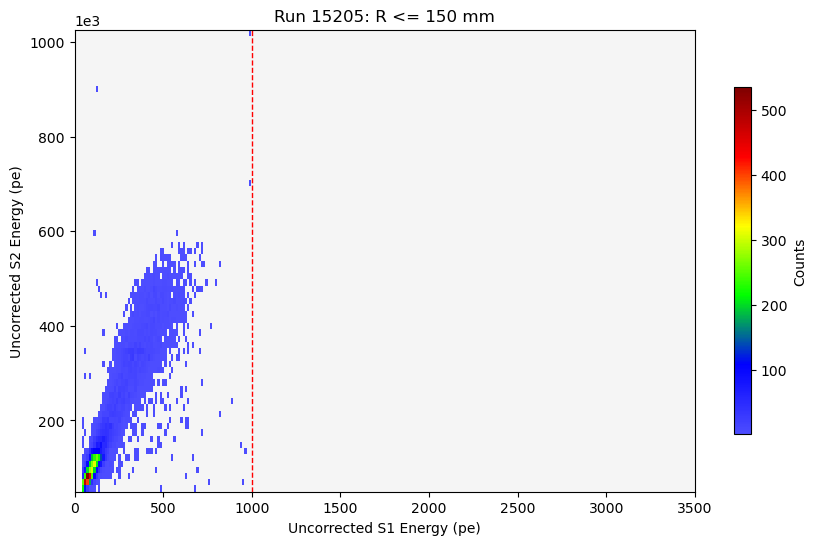

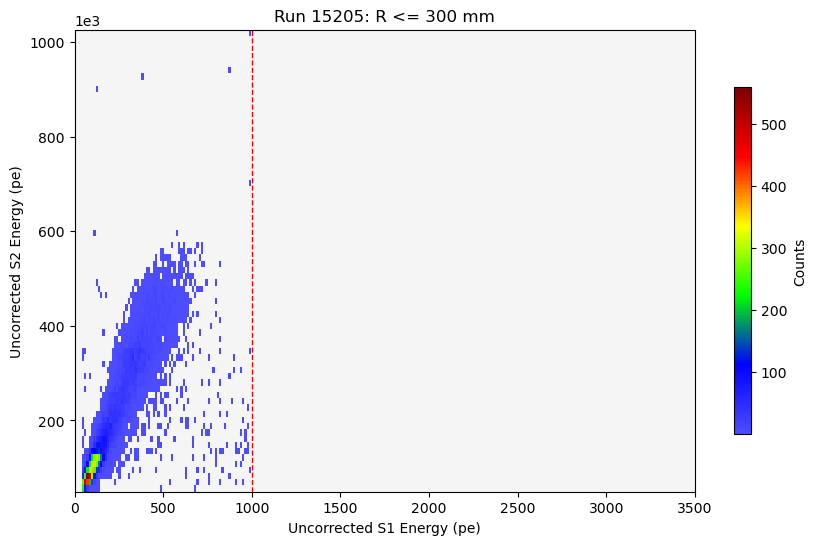

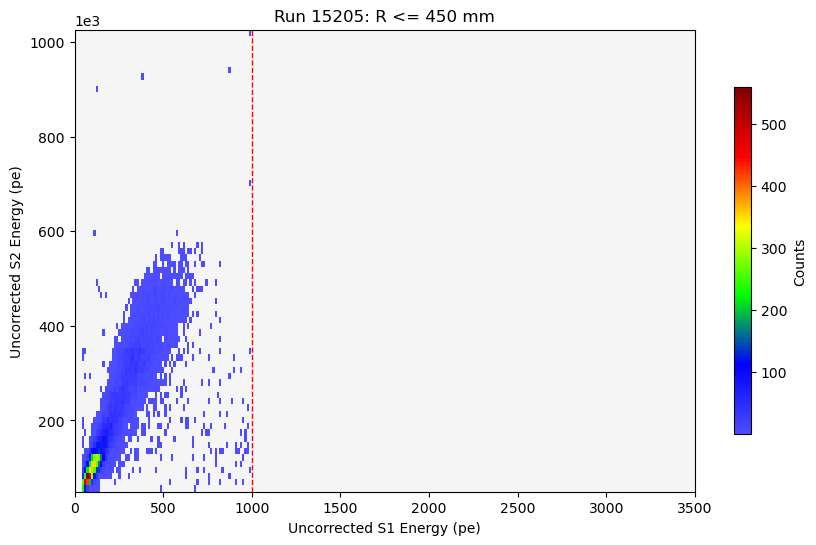

In [7]:
# Global
n_bins = 75
r_lim  = [150, 300, 450]

for r in r_lim:

    # Variables
    E1 = dst_df['S1e']
    E2 = dst_df['S2e']
    R  = np.sqrt(dst_df['X']**2 + dst_df['Y']**2)

    # Masking
    rad_mask = (R <= r)
    E1 = E1[rad_mask]
    E2 = E2[rad_mask]

    # 2D histogram
    S2e_S1e_map, ex, ey = pt.hist_2D(E1, E2, x_bins=n_bins, y_bins=n_bins)
    S2e_S1e_map         = np.ma.masked_where(S2e_S1e_map==0, S2e_S1e_map)         # Zero values masked

    # ----- Plotting ----- #
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(ex, ey, S2e_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
    plt.colorbar(label='Counts', shrink=0.75)
    plt.xlabel('Uncorrected S1 Energy (pe)')
    plt.xlim(0, 3.5e3)
    plt.ylabel('Uncorrected S2 Energy (pe)')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    plt.title(f'Run {run_id}: R <= {r} mm')

    # Limit line
    plt.axvline(x=1e3, c='red', ls='--', lw=1)

    plt.gca().set_facecolor("whitesmoke")
    plt.show()

### Cuts Definiton

In [3]:
def selection_criteria(group):
    """
    Defines the selection criteria to filter event-level data.

    This function is applied to grouped data (e.g., grouped by 'event') 
    to determine whether each group meets the specified conditions.

    Parameters:
        group (pd.DataFrame): A DataFrame representing a single event's data, 
                              grouped by a common identifier (e.g., 'event').

    Returns:
        bool: True if the group satisfies all selection criteria, False otherwise.
    """
    return (
                # Multiplicity
                (group['nS1'].sum() == 1) &
                (group['nS2'].sum() == 1) &

                # S1 Pulse
                (group['S1e'].sum() < 600)
           )

## Store Selection by LDC

In [4]:
# ----- Run Information ----- #
run_id = 15205

In [6]:
# ----- Preliminary ----- #
# NEXT data directory
data_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/DATA/NEXT100/'

# Table paths inside the HDF5 file. These are the keys used to access the datasets.
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

# Columns to drop in each DataFrame
# These columns are not needed for the analysis and can be removed to save memory.
dst_drop  = ['s1_peak', 's2_peak', 'Xrms', 'Yrms', 'Zrms', 'R', 'Phi']
reco_drop = ['npeak', 'Xpeak', 'Ypeak', 'nsipm', 'Xrms', 'Yrms', 'Qc', 'track_id', 'Ep']

# ----- Output Config ----- #
output_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/'
output_filename = f'run_{run_id}_custom_sophronia.h5'
output_filepath = os.path.join(output_dir, output_filename)

# Initialize empty lists to store the DataFrames
all_sel_dst  = []
all_mat_reco = []
files_counter = 0

# ----- LDC Loop ----- #
for ldc in range(1, 8):

    # HDF5 directory
    h5_dir = os.path.join(data_dir, f'analysis/{run_id}/hdf5/prod/v2.3.1/20250410/sophronia/trigger2/ldc{ldc}/')
    print('Reading HDF5 files from:', h5_dir)

    # ----- File Processing Loop ----- #
    # Get the list of all HDF5 files in the directory
    h5_files = sorted(glob.glob(os.path.join(h5_dir, "*.h5")))
    if not h5_files:
        raise FileNotFoundError(f"No HDF5 files found in the directory: {h5_dir}")

    print(f"\nFound {len(h5_files)} HDF5 files to process...\n")

    start_time = time.time()

    # ----- Data Loading, Selection and Matching ----- #
    for i, file_path in enumerate(h5_files):
        file_name = os.path.basename(file_path)
        print(f"--- Processing file {i+1}/{len(h5_files)}: {file_name} ---")

        files_counter += 1

        try:
            
            # ----- Dorothea ----- #
            dst_df = pd.read_hdf(file_path, key=dorothea)
            dst_df.drop(columns=dst_drop, inplace=True, errors='ignore')        # Drop unnecessary columns
            sel_dst_df = dst_df.groupby('event').filter(selection_criteria)     # Filter events based on criteria

            # Store the selected events
            if sel_dst_df.empty:
                print("\nNo events met the selection criteria in this file.")
                continue

            # Get unique event IDs that passed the selection
            selected_event_ids = sel_dst_df['event'].unique()

            # Store the selected DST data for this file
            all_sel_dst.append(sel_dst_df)

            # ----- Sophronia ----- # 
            try:

                reco_df = pd.read_hdf(file_path, key=sophronia)

            except KeyError:
                print(f"    Skipping event matching: '{sophronia}' table not found in this file.")
                continue

            reco_df.drop(columns=reco_drop, inplace=True, errors='ignore')      # Drop unnecessary columns
            
            # ----- Matching by Event ID ----- #            
            matched_reco_df = reco_df[reco_df['event'].isin(selected_event_ids)].copy() 

            if not matched_reco_df.empty:
                # Store the matched RECO data for this file
                all_mat_reco.append(matched_reco_df)
            else:
                print("    Warning: No matching Sophronia events found for selected DST events.")

        except FileNotFoundError:
            print(f"   Error: File '{file_name}' not found during loop (should not happen if glob worked).")
        except KeyError as e:
            print(f"   Error: Table (key) '{e}' not found in file '{file_name}'. Skipping this file.")
        except Exception as e:
            print(f"   Error: Unexpected error processing file '{file_name}'\n{e}")

    loop_duration = time.time() - start_time
    print(f"\n--- File processing loop finished in {loop_duration:.2f} seconds ---")

# ----- Fin del Bucle LDC ----- #
print(f"\n--- Procesamiento de todos los LDCs completado. Total de archivos HDF5 individuales procesados: {files_counter} ---")

# ----- Data Concatenation ----- #
# Concatenate all selected DST DataFrames into a single DataFrame
final_dst_df  = pd.DataFrame()
final_reco_df = pd.DataFrame()

if all_sel_dst:
    print(f"\nConcatenating selected DST data from {len(all_sel_dst)} files...")
    start_concat_dst = time.time()
    final_dst_df = pd.concat(all_sel_dst, ignore_index=True)
    print(f"   Final selected DST DataFrame dimensions: {final_dst_df.shape}")
    print(f"   DST concatenation took {time.time() - start_concat_dst:.2f} seconds.")
else:
    print("\nNo selected DST data was accumulated from any file.")

if all_mat_reco:
    print(f"\nConcatenating matched RECO data from {len(all_mat_reco)} files...")
    start_concat_reco = time.time()
    final_reco_df = pd.concat(all_mat_reco, ignore_index=True)
    print(f"   Final matched RECO DataFrame dimensions: {final_reco_df.shape}")
    print(f"   RECO concatenation took {time.time() - start_concat_reco:.2f} seconds.")
else:
    print("\nNo matched RECO data was accumulated from any file.")

# ----- Save Combined Data ----- #
if not final_dst_df.empty or not final_reco_df.empty:
    print(f"\nSaving combined data to HDF5 file:")
    start_save = time.time()
    try:
        # Save selected DST data if it exists
        if not final_dst_df.empty:
            final_dst_df.to_hdf(
                                    output_filepath, 
                                    key=dorothea, 
                                    mode='w',                   # Write mode (overwrites file if exists)
                                    complevel=5,                # Compression level (0-9)
                                    complib='blosc',
                                    format='table'              # Recommended format for potential querying/appending
                                )
            print(f"  - Saved selected DST data to key '{dorothea}'.")
        
        # Save matched RECO data if it exists
        if not final_reco_df.empty:
            # Use mode='a' (append) if DST data was already written to the same file
            mode = 'a' if not final_dst_df.empty else 'w' 
            final_reco_df.to_hdf(
                                    output_filepath, 
                                    key=sophronia, 
                                    mode=mode,                                          
                                    complevel=5,
                                    complib='blosc',
                                    format='table'
                                )
            print(f"  - Saved matched RECO data to key '{sophronia}'.")
            
        print(f"Successfully saved data in {time.time() - start_save:.2f} seconds.")

    except Exception as e:
        print(f"\nError saving data to HDF5 file '{output_filepath}'\n{e}")
else:
    print("\nNo data to save (both final DST and RECO DataFrames are empty).")

print(f'\nOutput stored in: {output_filepath}')

print("\n--- Y ya, eso es todo, eso es todo ---")

Reading HDF5 files from: /lustre/ific.uv.es/prj/gl/neutrinos/NEXT/DATA/NEXT100/analysis/15205/hdf5/prod/v2.3.1/20250410/sophronia/trigger2/ldc1/

Found 2056 HDF5 files to process...

--- Processing file 1/2056: run_15205_0000_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 2/2056: run_15205_0001_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 3/2056: run_15205_0002_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 4/2056: run_15205_0003_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 5/2056: run_15205_0004_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 6/2056: run_15205_0005_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 7/2056: run_15205_0006_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 8/2056: run_15205_0007_ldc1_trg2.v2.3.1.20250410.HEDesman.sophronia.h5 ---
--- Processing file 9/2056: run_15205_0008_ldc1_trg2.v2.3

# Estimate RAM Memory

In [ ]:
# ----- Run & LDC Information ----- #
run_id = 15205
ldc_id = 3

# ----- Preliminary ----- #
# NEXT data directory
data_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/DATA/NEXT100/'

# HDF5 directory
h5_dir = os.path.join(data_dir, f'analysis/{run_id}/hdf5/prod/v2.3.1/20250410/sophronia/trigger2/ldc{ldc_id}/')
print('Reading HDF5 files from:', h5_dir)

# Table paths inside the HDF5 file. These are the keys used to access the datasets.
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

# Columns to drop in each DataFrame
# These columns are not needed for the analysis and can be removed to save memory.
dst_drop  = ['s1_peak', 's2_peak', 'R', 'Phi', 'Xrms', 'Yrms', 'Zrms']
reco_drop = ['npeak', 'Xpeak', 'Ypeak', 'Xrms', 'Yrms', 'Qc', 'track_id', 'Ep']

# ----- File Processing Loop ----- #
# Get the list of all HDF5 files in the directory
h5_files = glob.glob(os.path.join(h5_dir, "*.h5"))
if not h5_files:
    raise FileNotFoundError(f"No HDF5 files found in the directory: {h5_dir}")

print(f"\nFound {len(h5_files)} HDF5 files to process.")

# Sample for estimation
sample_fraction = 0.1
num_sample_files = max(1, int(len(h5_files) * sample_fraction))
num_sample_files = min(num_sample_files, len(h5_files))

# Select the random sample
sample_h5_files = random.sample(h5_files, num_sample_files)
print(f"\n--- ESTIMATION RUN ---")
print(f"Processing a sample of {num_sample_files} files (out of {len(h5_files)} total) to estimate memory.")

# Initialize empty lists to store the DataFrames from each file
all_selected_dst = []
all_matched_reco = []

start_time = time.time()

# ----- Data Loading, Selection and Matching ----- #
for i, file_path in enumerate(sample_h5_files):
    file_name = os.path.basename(file_path)
    print(f"\n--- Processing file {i+1}/{len(h5_files)}: {file_name} ---")

    try:
        
        # ----- Dorothea ----- #
        # print(f"\nLoading '{dorothea}' table...")
        dst_df = pd.read_hdf(file_path, key=dorothea)

        # print(f"-> '{dorothea}' loaded successfully!")
        # print(f"OG DataFrame dimensions (rows, columns): {dst_df.shape}")
        # print(f"Available columns: {dst_df.columns.tolist()}")
        # print(f"   Dropping {len(dst_drop)} specified columns from DST data...")
        # Use axis=1 to specify dropping columns (axis=0 would be rows)
        # Use errors='ignore' so it doesn't fail if a column listed is already missing
        dst_df.drop(columns=dst_drop, inplace=True, errors='ignore') 
        # print(f"   DST DataFrame dimensions after dropping columns: {dst_df.shape}")

        # Applying selection criteria
        sel_dst_df = dst_df.groupby('event').filter(crudo.selection_criteria)
        # print(f"   Selected DataFrame dimensions (rows, columns): {sel_dst_df.shape}")

        # ----- Matching Events with Sophronia ----- #
        if sel_dst_df.empty:
            print("\nNo events met the selection criteria in this file.")
            continue  # Skip to the next file

        # Get unique event IDs that passed the selection
        selected_event_ids = sel_dst_df['event'].unique()
        # print(f"   Number of unique events selected: {len(selected_event_ids)}")
        # Store the selected DST data for this file
        all_selected_dst.append(sel_dst_df)

        # Sophronia
        # print(f"\nLoading '{sophronia}' table...")
        try: 
            reco_df = pd.read_hdf(file_path, key=sophronia)
            # print(f"-> '{sophronia}' loaded successfully!")
            # print(f"   OG RECO DataFrame dimensions (rows, columns): {reco_df.shape}")

        except KeyError:
             print(f"   Skipping RECO match: RECO table '{sophronia}' not found in this file.")
             continue # Skip RECO matching for this file, but keep selected DST

        # Drop unnecessary columns from RECO DataFrame
        # print(f"   Dropping {len(reco_drop)} specified columns from RECO data...")
        reco_df.drop(columns=reco_drop, inplace=True, errors='ignore')
        # print(f"   RECO DataFrame dimensions after dropping columns: {reco_df.shape}")

        # print(f"\nMatching RECO data with the {len(selected_event_ids)} selected events...")
        if 'event' not in reco_df.columns:
            print("Error: 'event' column not found in the RECO DataFrame. Cannot perform matching.")
            continue  # Skip to the next file

        
        # Filter the RECO DataFrame to keep only rows where the 'event' ID
        # is present in the list of selected_event_ids
        matched_reco_df = reco_df[reco_df['event'].isin(selected_event_ids)].copy() 

        # print("-> Matching complete.")
        # print(f"   Final matched RECO DataFrame dimensions (rows, columns): {matched_reco_df.shape}")

        if not matched_reco_df.empty:
            # Store the matched RECO data for this file
            all_matched_reco.append(matched_reco_df)
        else:
            print("   Warning: No matching RECO events found for selected DST events.")

    except FileNotFoundError:
        print(f"   Error: File '{file_name}' not found during loop (should not happen if glob worked).")
    except KeyError as e:
        print(f"   Error: Table (key) '{e}' not found in file '{file_name}'. Skipping this file.")
    except Exception as e:
        print(f"   Error: Unexpected error processing file '{file_name}': {e}")

loop_duration = time.time() - start_time
print(f"\n--- File processing loop finished in {loop_duration:.2f} seconds ---")

# ----- Data Concatenation ----- #
# Concatenate all selected DST DataFrames into a single DataFrame
final_dst_df = pd.DataFrame()
final_reco_df = pd.DataFrame()

estimated_dst_mem_mb = 0
estimated_reco_mem_mb = 0

if all_selected_dst:
    print(f"\nConcatenating selected DST data from {len(all_selected_dst)} files...")
    start_concat_dst = time.time()
    final_dst_df = pd.concat(all_selected_dst, ignore_index=True)
    dst_mem_bytes = final_dst_df.memory_usage(deep=True).sum()
    dst_mem_mb = dst_mem_bytes / (1024**2)
    print(f" -> Sample DST DataFrame: {final_dst_df.shape}, Memory: {dst_mem_mb:.2f} MB")
    # Estimate total memory needed for DST
    extrapolation_factor = len(h5_files) / num_sample_files
    estimated_dst_mem_mb = dst_mem_mb * extrapolation_factor
    print(f" ---> Estimated TOTAL DST Memory: {estimated_dst_mem_mb / 1024:.2f} GB")
    del final_dst_df # Optional: Free memory used by sample df
else:
    print("No DST data collected in the sample.")

print(f"   DST concatenation took {time.time() - start_concat_dst:.2f} seconds.")


if all_matched_reco:
    print(f"\nConcatenating matched RECO data from {len(all_matched_reco)} files...")
    start_concat_reco = time.time()
    final_reco_df = pd.concat(all_matched_reco, ignore_index=True)
    reco_mem_bytes = final_reco_df.memory_usage(deep=True).sum()
    reco_mem_mb = reco_mem_bytes / (1024**2)
    print(f" -> Sample RECO DataFrame: {final_reco_df.shape}, Memory: {reco_mem_mb:.2f} MB")
    # Estimate total memory needed for RECO
    extrapolation_factor = len(h5_files) / num_sample_files
    estimated_reco_mem_mb = reco_mem_mb * extrapolation_factor
    print(f" ---> Estimated TOTAL RECO Memory: {estimated_reco_mem_mb / 1024:.2f} GB")
    del final_reco_df # Optional: Free memory used by sample df
else:
    print("No RECO data collected in the sample.")
    
# Estimate combined total
total_estimated_mem_gb = (estimated_dst_mem_mb + estimated_reco_mem_mb) / 1024
print(f"\n---> Estimated TOTAL COMBINED Memory (DST + RECO): {total_estimated_mem_gb:.4f} GB")


print(f"   RECO concatenation took {time.time() - start_concat_reco:.2f} seconds.")


print("\n--- Overall processing finished ---")